In [1]:
# Set the matplotlib magic. This line is specific to ipython notebooks.
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# Import some useful module.
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
import numpy as np
import math

# Import the system module.
import mag_lev

In [2]:
# Format Plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 150

# Change font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [3]:
MAX_VOLTAGE = 10.0 # [V]
R = 2.41 # Coil Resistance [ohms]

## System Characterization
This section focuses on running experiments to understand the dynamics of the hall effect sensor, electromagnet circuit, and the permanent magnet

No magnet, no electromagnet - $$V_h = 2.5 V$$

In [116]:
sys_1 = mag_lev.MagLev()
sys_1.start_system()
sys_1.set_max_coil_voltage_magnitude(MAX_VOLTAGE)

Starting system...
System started


In [117]:
# Test to show relationship between magnet distance and hall voltage

time_list = []
V_h_list = []

sys_1.remove_magnet()
time.sleep(1)

sample_t = 0.2 # Amount of time to take measurements over
distances = np.linspace(0, 0.1, 21) # 1 cm distances
idx = 0

start_t = time.time()
last_measurement_t = time.time()

sys_1.set_object_mass(3.0e-3)
sys_1.hold_magnet_at_distance(distances[0])

measurements = []
positions = []

while (idx+1 != len(distances)):
    if (time.time() - last_measurement_t > sample_t):
        # Save measurement from last distance test
        positions.append(distances[idx])
        measurements.append(sys_1.get_hall_voltage())
        
        idx += 1
        sys_1.hold_magnet_at_distance(distances[idx])
        last_measurement_t = time.time()
        
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_1.get_hall_voltage())

You cannot remove a magnet that is not present.


In [118]:
# Check this plot to make sure we've waited long enough for dynamics to settle
#plt.plot(time_list, V_h_list)

Text(0.5, 0, 'Magnet Position (m)')

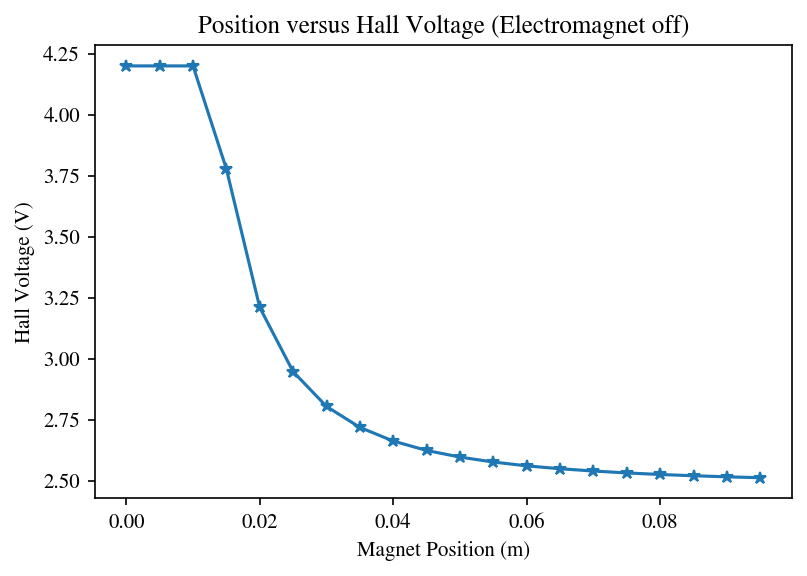

In [119]:
plt.plot(positions, measurements, '*-')
plt.title("Position versus Hall Voltage (Electromagnet off)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Magnet Position (m)")

In [18]:
# Test to show relationship between electromagnet PWM and hall voltage

time_list = []
V_h_list = []

sys_1.remove_magnet()
time.sleep(1)

sample_t = 0.2 # Amount of time to take measurements over (to let dynamics "settle")
PWMs = np.linspace(0, 225, 25)
idx = 0

measurements = []
PWM_list = []

start_t = time.time()
last_measurement_t = time.time()

sys_1.set_amplifier_input(PWMs[0], sys_1.FORWARD)

while (idx+1 != len(PWMs)):
    if (time.time() - last_measurement_t > sample_t):
        # Save measurement from last PWM test
        measurements.append(sys_1.get_hall_voltage())
        PWM_list.append(PWMs[idx])
        
        idx += 1
        sys_1.set_amplifier_input(PWMs[idx], sys_1.FORWARD)
        last_measurement_t = time.time()
        
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_1.get_hall_voltage())

In [19]:
# Check this plot to make sure we've waited long enough for dynamics to settle
# plt.plot(time_list, V_h_list) 

Text(0.5, 0, 'PWM signal (0 - 255)')

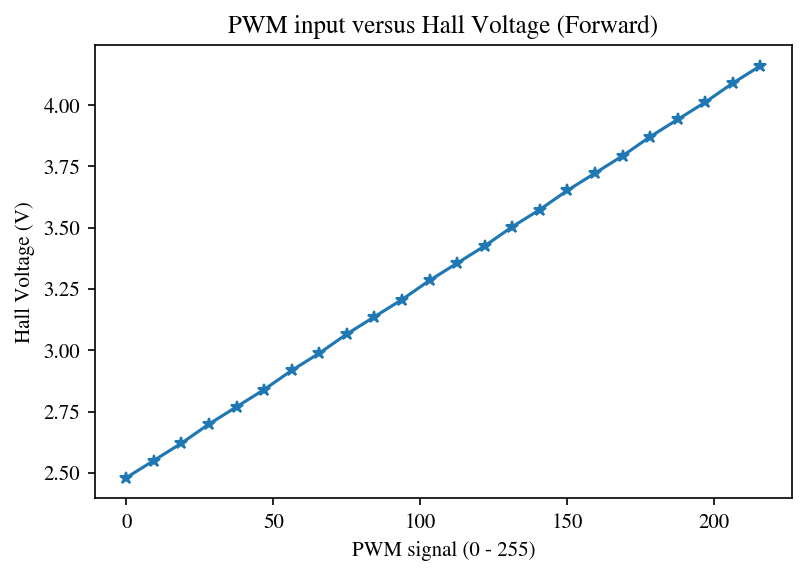

In [20]:
plt.plot(PWM_list, measurements, '*-')
plt.title("PWM input versus Hall Voltage (Forward)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("PWM signal (0 - 255)")

In [21]:
# How do these stack together? Let's compute the position vs hall voltage graph again with the electromagnet on
# Using PWM 100 for testing
# PWM 100 corresponds with hall voltage of 3.25 with no magnet

time_list = []
V_h_list = []

sys_1.remove_magnet()
sys_1.set_amplifier_input(100, sys_1.FORWARD) # Just using mid-range PWM for testing
time.sleep(1)

sample_t = 0.2 # Amount of time to take measurements over
distances = np.linspace(0, 0.1, 21) # 1 cm distances
idx = 0

start_t = time.time()
last_measurement_t = time.time()

sys_1.set_object_mass(3.0e-3)
sys_1.hold_magnet_at_distance(distances[0])

measurements = []
positions = []

while (idx+1 != len(distances)):
    if (time.time() - last_measurement_t > sample_t):
        # Save measurement from last distance test
        positions.append(distances[idx])
        measurements.append(sys_1.get_hall_voltage())
        
        idx += 1
        sys_1.hold_magnet_at_distance(distances[idx])
        last_measurement_t = time.time()
        
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_1.get_hall_voltage())

You cannot remove a magnet that is not present.


In [22]:
# Check this plot to make sure we've waited long enough for dynamics to settle
# plt.plot(time_list, V_h_list) 

Text(0.5, 0, 'Magnet Position (m)')

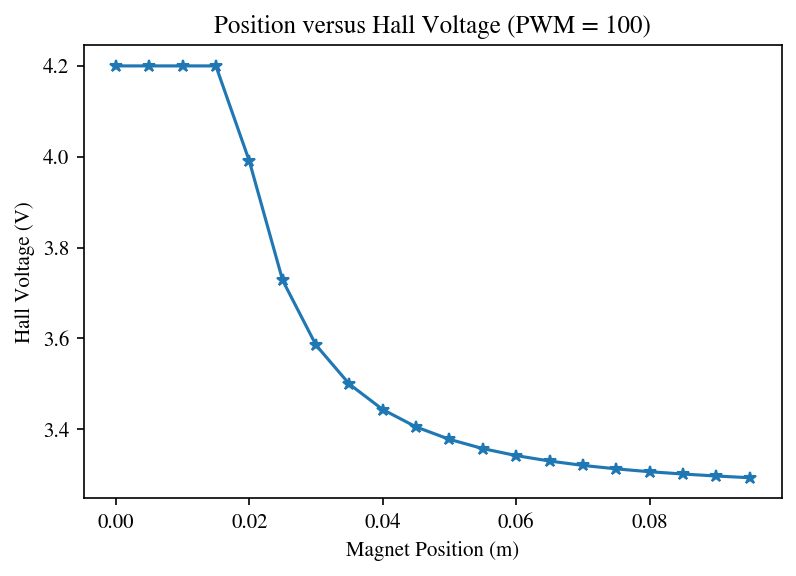

In [23]:
plt.plot(positions, measurements, '*-')
plt.title("Position versus Hall Voltage (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Magnet Position (m)")

### Conclusions
We don't actually need to worry about the precise value of B, since we know hall voltage is proportional to B (aka the B that results from a voltage of 3.5 volts is the same regardless of whether it came from the electromagnet or the permanent magnet)

From the final test, we can see that the position versus hall voltage graph simply shifted up based on the value of the electromagnet PWM (assuming the magnet's dynamics have settled) 

This means we should be able to subtract out the effect of the electromagnet to get a clean position reading (especially after we model the electromagnet's inductance - the hall voltage seems directly proportional to the electromagnet's current)

Next step: determine relationship between PWM and current, write a function that computes position based on magnet current given the info seen here

## Sensor Calibration
This section focuses on running experiments to compute constants that weren't given, such as hall effect sensor coefficients, electromagnet inductance, and the permanent magnet B field coefficients

### Calibrating Inductance

Since the circuit's relationship between current and voltage can be modeled as a linear system whose transfer function can be written as 

$$\frac{I}{V} = \frac{1}{R + Ls}$$

We can compute the inductance by observing the electromagnet's time constant

For a first order system of the form 
$$\frac{k}{\tau s + 1}$$

$\tau$ represents the time constant. With this information, we can conclude that the time constant of our system should be 
$$\tau = \frac{L}{R}$$


In [5]:
sys_3 = mag_lev.MagLev()
sys_3.start_system()
sys_3.set_max_coil_voltage_magnitude(MAX_VOLTAGE)

Starting system...
System started


In [6]:
time_list = []
V_h_list = []

sys_3.remove_magnet()
time.sleep(1)

start_t = time.time()

test_PWM = 100
sys_3.set_amplifier_input(test_PWM, sys_3.FORWARD)

while (time.time() - start_t < 0.2):        
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_3.get_hall_voltage())

You cannot remove a magnet that is not present.


In [7]:
# Computing Inductance
# Model dictates time constant is R/L

max_V_h = max(V_h_list)
min_V_h = min(V_h_list)

# Expected value of V_h at time constant
V_h_tc = (1- 1/math.e) * (max_V_h - min_V_h) + min_V_h 

# Compute differences
deltas = abs(np.array(V_h_list) - V_h_tc) 

# Get closest index
idx = np.argmin(deltas)

# Compute time constant
tc = time_list[idx] - time_list[0] 

# Compute inductance
L = tc*R

L

0.014910004138946534

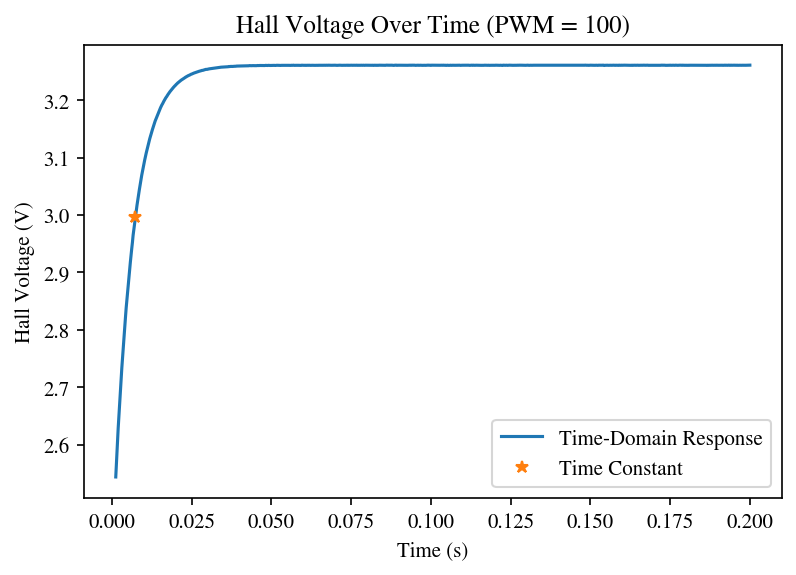

In [8]:
plt.plot(time_list, V_h_list, label="Time-Domain Response")
plt.plot(time_list[idx], V_h_list[idx], "*", label="Time Constant")
plt.title("Hall Voltage Over Time (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Time (s)")
plt.legend()

### Calibrating Hall Effect Sensor

Since it appears that electromagnet current is directly proportional to hall voltage, we can find a scaling constant to convert directly from hall voltage to current

$$
I = V_h * c
$$

We can do this as follows (assuming the system has already reached steady-state):
1. $V_e = \frac{PWM}{255} * V_{max}$
2. $I = \frac{V_e}{R}$
3. $c = \frac{I}{V_h}$

Note: This computes the hall voltage contribution from the electromagnet - it should be added to $2.5V$ to get the actual hall voltage value

In [18]:
# Compute scaling constant between electromagnet current and hall voltage

# Compute electromagnet voltage
V_e = test_PWM/255 * MAX_VOLTAGE

# Compute steady-state current 
I = V_e / R

# Compute scaling constant
c_I_to_V_h = I / V_h_list[-1]

c_I_to_V_h

0.49895169189038646

This analysis created the `currentToHallVoltage` function below

### Calibrating Permanent Magnet
Now that we have the electromagnet's contribution to the hall voltage, we can create a function that allows the hall effect sensor to act like a position sensor

We know that the magnet's B field is directly proportional to the hall effect sensor's voltage, so let's start with the equation for a permanent magnet B field 
$$
\mathbf{B}(\mathbf{r}) = 
    \frac{\mu_0}{4 \pi} 
    \frac{3 \mathbf{\hat{r}} (\mathbf{\hat{r}} \cdot \mathbf{m}) - \mathbf{m}}{|r|^3}
$$
(This equation models the magnet as a magnetic dipole moment, which doesn’t consider the shape of the magnet at all. We assume that $\hat{r}$ is perpendicular to the magnetic dipole moment $m$) 

Reference: https://en.wikipedia.org/wiki/Magnetic_moment#Magnetic_pole_model

If we assume $\mathbf{m}$ is a constant and that we have the magnetic field perfectly aligned, we can separate all of the constants out as follows:

$$
\mathbf{B}(\mathbf{r}) = 
    \frac{\mu_0 (2\mathbf{m})}{4 \pi} 
    \frac{1}{|r|^3}
$$

Which can be equivalently written as
$$
\mathbf{B}(\mathbf{r}) = 
    c
    \frac{1}{|r|^3}
$$

Where $c$ is a constant representing $\frac{\mu_0 (2\mathbf{m})}{4 \pi} $

In [121]:
from scipy.optimize import curve_fit

In [122]:
def func(x, a, b, c):
    return a/(x+c)**b

In [158]:
def func(x, a, b, c):
    return a/(x + c)**3 + b

In [164]:
popt, pcov = curve_fit(func, positions[5:], measurements[5:])
popt # Note that b = 2.5, which is our offset

array([2.60302302e-05, 2.49423136e+00, 1.36477508e-02])

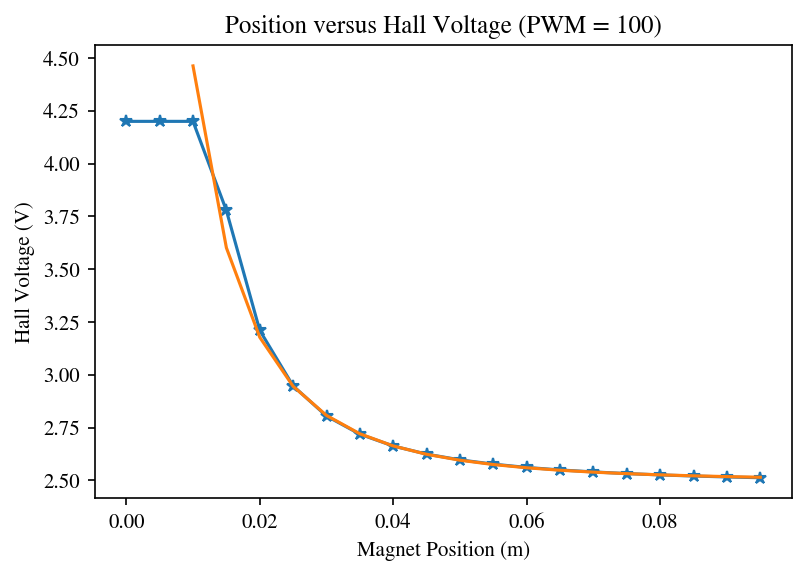

In [161]:
plt.plot(positions, measurements, '*-')
plt.title("Position versus Hall Voltage (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Magnet Position (m)")

plt.plot(positions[2:], func(np.array(positions[2:]), *popt))

Now that we have a calibration function in the form 
$$
\frac{a}{(y + c)^3} + b = V_h
$$

where
- $a,b,c$: lumped parameter constants
- $y$: magnet position
- $V_h$: Hall voltage

we can invert this function to convert from hall voltage to magnet position. Inverting this function results in the equation
$$
\sqrt[3]{\frac{a}{(V_h -b)^3}} - c = y
$$

This analysis created the `convertToDistance` function below

In [6]:
# Testing convertToDistance

sys_4 = mag_lev.MagLev()
sys_4.start_system()
sys_4.set_max_coil_voltage_magnitude(MAX_VOLTAGE)

Starting system...
System started


In [ ]:
# TODO: Need to keep track of current in main model - 
# Modify "real-life-test" to keep track of expected current based on 
# inductor model

# Use position as input to model

In [ ]:
time_list = []
V_h_list = []

sys_4.remove_magnet()
time.sleep(1)

start_t = time.time()

test_PWM = 100
sys_4.set_amplifier_input(test_PWM, sys_3.FORWARD)

while (time.time() - start_t < 0.2):        
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_4.get_hall_voltage())
    
    # Convert from V_h to I
    c_I_to_V_h
    

In [181]:
# TODO: Linearize around 0.04 or similar

## Model

In [4]:
# Constants
L = 0.014539394378662111              # Inductance
c_I_to_V_h = 0.49895169189038646      # Scaling constant between electromagnet current and hall voltage

# Lumped parameter constants for V_h to position
c1_V_h_to_y, c2_V_h_to_y, c3_V_h_to_y = 2.60302302e-05, 2.49423136e+00, 1.36477508e-02



In [8]:
# Modeling Functions
def PWMtoVolts(PWM, max_volts):
    return PWM/255 * max_volts

def currentToHallVoltage(I):
    return c_I_to_V_h * I

def convertToDistance(V_h, I):
    # Computes distance of permanent magnet from electromagnet based on
    # input hall voltage by subtracting contribution from electromagnet
    
    # Compute hall voltage contribution from electromagnet
    V_h_from_e = c_I_to_V_h * I
    
    # Compute hall voltage contribution from magnet
    V_h_from_m = V_h - V_h_from_e
    
    # Convert from hall voltage to position
    return (c1_V_h_to_y/(V_h_from_m - c2_V_h_to_y)**3)**(1/3) - c3_V_h_to_y
    

In [9]:
convertToDistance(4, 0)

0.006034182464531645

In [10]:
# Creating our own model to compare to the "real world" model
class MagLevModel():
    def __init__(self, dt=0.001, max_volts=10.0, object_mass=0.03, object_start_dist=0.01):
        # Parameters
        self.max_volts = max_volts          # Default to 10 [V]
        self.mass = object_mass             # Permanent magnet mass [kg]
        self.dt = dt                        # Timestep for approximation [s]
        self.start_dist = object_start_dist # Starting distance        
            
        # State variables
        self.V_e = 0                    # Electromagnet voltage
        self.I = 0                      # Electromagnet current
        self.dist = self.start_dist     # Magnet position
        self.t = 0                      # Current model time
        
        # Data recording
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        
        self.FORWARD = 1
        self.REVERSE = -1   

        
    def set_amplifier_input(self, PWM, direction):
        self.V_e = direction * PWMtoVolts(PWM, self.max_volts)
        
    def get_hall_voltage(self):
        # Dependent on both electromagnet voltage and magnet position
        pass
        
    def reset_model(self):
        # Reset state variables
        self.V_e = 0
        self.I = 0 
        self.dist = self.start_dist
        self.t = 0
        
    def testHallVoltageFromElectromagnet(self, end_t, test_PWM):
        self.reset_model()

        while self.t < end_t:
            self.t += self.dt
            
            model.set_amplifier_input(test_PWM, model.FORWARD)
            
            # TODO: see if real model has a current limit
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            self.V_h = currentToHallVoltage(self.I)
            
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            
#     def testPositionComputation(self, end_t, test_PWM):
#         self.reset_model()

#         while self.t < end_t:
#             self.t += self.dt
            
#             model.set_amplifier_input(test_PWM, model.FORWARD)
            
#             # TODO: see if real model has a current limit
#             dI = ((self.V_e - self.I * R) / L) * self.dt
#             self.I += dI
            
#             self.V_h = currentToHallVoltage(self.I)
            
#             self.dist = convertToDistance(self.V_h, self.I)
            
#             self.ts.append(self.t)
#             self.Is.append(self.I)
#             self.V_hs.append(self.V_h)
#             self.ys.append(self.dist)
        
            
# #             self.ys = []
            
#                 # Update V_e based on controller 
#             # TODO
#             # TEMP
        


Text(0.5, 0, 'Time (s)')

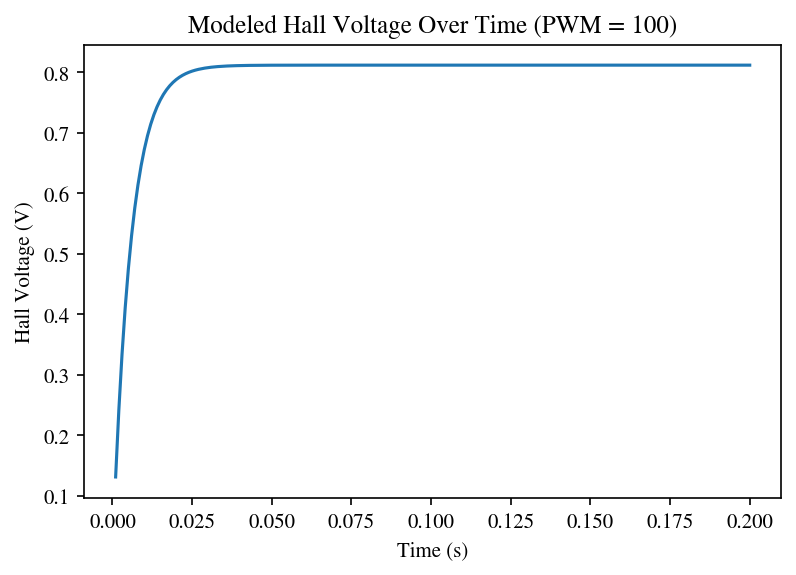

In [26]:
model = MagLevModel()
model.testHallVoltageFromElectromagnet(end_t = 0.2, test_PWM = 100)

plt.plot(model.ts, model.V_hs)
plt.title("Modeled Hall Voltage Over Time (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Time (s)")

In [13]:
# model = MagLevModel()
# model.testPositionComputation(end_t = 0.2, test_PWM = 100)

# plt.plot(model.ts, model.ys)
# plt.title("Modeled Position Over Time (PWM = 100)")
# plt.ylabel("Position (m)")
# plt.xlabel("Time (s)")

In [30]:
# Does the magnet stick with no voltage?

# Create the system object.
sys_2 = mag_lev.MagLev()
# sys_2.

# Start the system.
sys_2.start_system()
sys_2.set_object_mass(3.0e-3)
sys_2.set_amplifier_input(255, sys_2.FORWARD)
sys_2.hold_magnet_at_distance(0)
sys_2.release_magnet()
time.sleep(10)
# sys_2.remove_magnet()

sys_2.stop_system()

Starting system...
System started
System stopped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

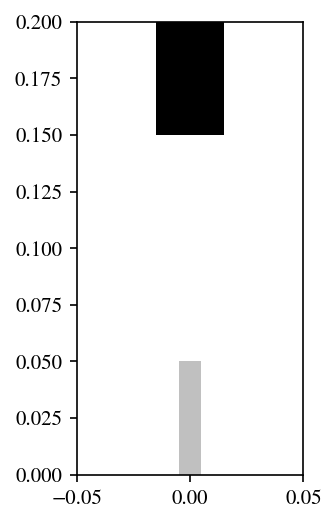

In [24]:
anim = sys_2.create_system_animation();

In [95]:
np.linspace(0, 0.1, 11)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [ ]:
# # sys_1.set_amplifier_input(0, example_sys.FORWARD)
# # sys_1.set_amplifier_input(225, example_sys.FORWARD)

# while (time.time()-start_t < 1):
#     time_list.append(time.time() - start_t)
#     V_h_list.append((sys_1.get_hall_voltage()))

# # while (time.time()-start_t < 0.5):
# #     time_list.append(time.time() - start_t)
# #     V_h_list.append((sys_1.get_hall_voltage()))

# # sys_1.hold_magnet_at_distance(0.1)

# # while (time.time()-start_t < 1):
# #     time_list.append(time.time() - start_t)
# #     V_h_list.append((sys_1.get_hall_voltage()))

In [2]:
# Create the system object.
example_sys = mag_lev.MagLev()

# Start the system.
example_sys.start_system()

# Set the amplifier's maximum voltage.
example_sys.set_max_coil_voltage_magnitude(10.0)

# Set the amplifier's voltage.
example_sys.set_amplifier_input(200, example_sys.FORWARD)

# Choose an object mass.
example_sys.set_object_mass(3.0e-3)

# Hold the magnet under the electromagnet.
example_sys.hold_magnet_at_distance(3.0e-2)

# Wait a moment and then remove the magnet.
time.sleep(1.0)
example_sys.remove_magnet()

# Wait a moment and then hold the magnet under the electromagnet again at a
# different distance farther away.
time.sleep(1.0)
example_sys.hold_magnet_at_distance(5.0e-2)

# Wait a moment and then release the magnet.
print("Let's see if the magnet falls.")
time.sleep(1.0)
example_sys.release_magnet()

# Watch what happens for a bit.
start_time = time.time()
end_time = 2.0

while time.time() - start_time < end_time:
    # print(example_sys.get_hall_voltage())
    pass

# Wait a moment and then hold the magnet under the electromagnet again but
# much closer.
time.sleep(1.0)
example_sys.hold_magnet_at_distance(3.0e-2)

# Wait a moment and then release the magnet.
print("Let's see if the magnet sticks.")
time.sleep(1.0)
example_sys.release_magnet()

# Watch what happens for a bit again.
start_time = time.time()

while time.time() - start_time < end_time:
    pass
    # print(example_sys.get_hall_voltage())

# Wait a moment and stop the system.
time.sleep(1.0)
example_sys.stop_system()

# Wait a moment to make sure the system fully stopped.

# Note that all the other waits were as desired except the following wait
# as the system will not give an animation if the system is not fully
# stopped.
time.sleep(1.0)

# After running up to this point, the notebook is about 4.8 [kB].

Starting system...
System started
Let's see if the magnet falls.
Let's see if the magnet sticks.
System stopped


In [3]:
# Sometimes the below commands can be finicky or require a refresh of the page.
# Sometimes they just take a while to load. Sometimes minutes.
# Note that two plots always seem to show up (although unclear why).

In [14]:
# Take a look. Make sure all the above makes sense given the animation.
# For some reason, this line causes the animation to display (although not smoothly).
anim = example_sys.create_system_animation();
# After running up to this point, the notebook is about 5.5 [kB].

You cannot create an animation because the system is not stopped.


In [5]:
# Use pyplot as a default, but likely the playback will be poor.
# plt.show()

In [6]:
# To remove the animation object to shrink the notebook, 
# run the following command and rerun the cell containing the plot above.
%reset_selective -f anim

In [5]:
# A nice video can be produced with the following command. This could take maybe 30 [s].
anim_video = HTML(anim.to_html5_video())
# After running up to this point, the notebook is about 68.4 [kB].

In [6]:
# Display the video.
anim_video

In [ ]:
# In order to shrink the notebook (which is important), 
# run the following then rerun the above cell containing the video.
%reset_selective -f anim_video

In [12]:
sys_1.
# sys_1.get_hall_voltage()

<module 'time' (built-in)>

<IPython.core.display.Javascript object>


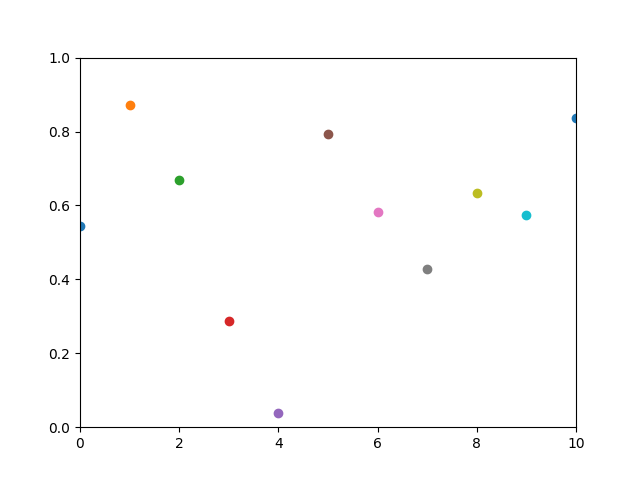

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.axis([0, 10, 0, 1])

for i in range(100):
    y = np.random.random()
    plt.scatter(i, y)
    plt.pause(0.05)

plt.show()